In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from datetime import timedelta

# Load and prepare data
df = pd.read_csv('storm_data.csv', parse_dates=['date'], index_col=0)
df = df.loc[df["S_prime"] < 1]
df = df.sort_values(['ticker', 'K', 'date', 't_prime']).reset_index(drop=True)

# Convert rates to daily
def black_scholes_delta(row):
    S = row['S']
    K = row['K']
    t = row['t_prime']/365  # Convert days to years
    r = row['rf']*365       # Annualize daily rate
    sigma = row['volatility'] * np.sqrt(365)  # Annualize daily volatility

    if t <= 1e-6:  # Handle expiration case
        return 1.0 if S > K else 0.0

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    return norm.cdf(d1)

df['BS_V_delta'] = df.apply(black_scholes_delta, axis=1)

In [118]:
# df = df.drop(columns=["opt_returns"])
dff = pd.read_csv('sstorm_data.csv', parse_dates=['date'], index_col=0)

In [110]:
pd.concat([df, dff], axis=0).reset_index().to_csv('storm_data.csv')

In [120]:
len(dff)

134086

In [117]:
df["ticker"].unique()

array(['BB', 'GME', 'JPM'], dtype=object)

In [3]:
def calculate_opt_returns(df):
    """
    Vectorized calculation of option returns with progress bar
    
    Parameters:
    df (pd.DataFrame): DataFrame containing columns ['K', 't_prime', 'date', 'ticker', 'S', 'opt_price']
    
    Returns:
    pd.Series: Series containing the calculated option returns
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Pre-calculate next day dates
    df['next_date'] = df['date'] + pd.Timedelta(days=1)
    
    # Initialize results array
    opt_returns = np.full(len(df), np.nan)
    
    # Split calculations based on t_prime
    t_prime_1_mask = df['t_prime'] == 1
    t_prime_other_mask = ~t_prime_1_mask
    
    # Process t_prime == 1 cases
    t_prime_1_df = df[t_prime_1_mask]
    if len(t_prime_1_df) > 0:
        for idx in tqdm(t_prime_1_df.index, desc="Processing t_prime=1"):
            row = t_prime_1_df.loc[idx]
            next_s = df['S'].loc[
                (df['ticker'] == row['ticker']) &
                (df['date'] == row['next_date'])
            ]
            if len(next_s) > 0:
                nom_ret = max(next_s.iloc[0] - row['K'], 0) 
                if nom_ret == 0:
                    ret = -1
                else:
                    ret = (nom_ret - row['opt_price']) / row['opt_price']
                opt_returns[idx] = ret
    
    # Process other t_prime cases
    t_prime_other_df = df[t_prime_other_mask]
    if len(t_prime_other_df) > 0:
        for idx in tqdm(t_prime_other_df.index, desc="Processing other t_prime"):
            row = t_prime_other_df.loc[idx]
            next_row = df[
                (df['ticker'] == row['ticker']) &
                (df['K'] == row['K']) &
                (df['date'] == row['next_date']) &
                (df['t_prime'] == row['t_prime'] - 1)
            ]
            if len(next_row) > 0:
                opt_returns[idx] = (next_row['opt_price'].iloc[0] - row['opt_price']) / row['opt_price']
    
    return pd.Series(opt_returns, index=df.index)

# Example usage:
if 'opt_returns' not in df.columns:
    result = calculate_opt_returns(df)
    df["opt_returns"] = result
    df.to_csv('storm_data.csv')


Processing t_prime=1:   0%|          | 0/7385 [00:00<?, ?it/s]

Processing other t_prime: 100%|██████████| 126413/126413 [14:30<00:00, 145.29it/s]


In [4]:
df["opt_returns"].describe()

count    106797.000000
mean         -0.061139
std           0.984959
min          -1.000000
25%          -0.234043
50%          -0.020528
75%           0.042131
max         212.000000
Name: opt_returns, dtype: float64

In [5]:
# count number of NaNs
df["opt_returns"].isna().sum(), df["opt_returns"].isna().sum() / len(df) 

(np.int64(27001), np.float64(0.20180421232006457))

In [74]:
import optuna
start_date = df["date"].min()
end_date = start_date + timedelta(days=30)
def objective(trial, df):
    sub_df = df.copy()
    min_ratio = trial.suggest_float("min_ratio", 0, 2, step=0.001)
    max_ratio = trial.suggest_float("max_ratio", 0.1, 5, step=0.1)
    min_vol = trial.suggest_int("min_vol", 1, 20)
    max_ratio = min_ratio*(1 + max_ratio)
    sub_df = sub_df.loc[(sub_df["date"] >= start_date) & (sub_df["date"] <= end_date)]
    sub_df = sub_df.loc[sub_df["opt_returns"].notna()]
    sub_df = sub_df.loc[sub_df["volume"] > min_vol]
    sub_df = sub_df.loc[sub_df["t_prime"] != 1]
    sub_df["ratio"] = sub_df["V"]/sub_df["opt_price"]
    returns = sub_df["opt_returns"].loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]  
    if len(returns) > 10:
        return -float("inf")
    return returns.mean()*252/(returns.std()* np.sqrt(252))

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, df), n_trials=1000)

[I 2025-01-30 20:52:42,754] A new study created in memory with name: no-name-660b6ede-7f64-4a31-9710-38b2ca1a9e55
[I 2025-01-30 20:52:42,779] Trial 0 finished with value: -inf and parameters: {'min_ratio': 0.371, 'max_ratio': 1.1, 'min_vol': 14}. Best is trial 0 with value: -inf.
[I 2025-01-30 20:52:42,797] Trial 1 finished with value: -inf and parameters: {'min_ratio': 1.461, 'max_ratio': 0.2, 'min_vol': 9}. Best is trial 0 with value: -inf.
[I 2025-01-30 20:52:42,814] Trial 2 finished with value: -inf and parameters: {'min_ratio': 1.216, 'max_ratio': 2.2, 'min_vol': 12}. Best is trial 0 with value: -inf.
[I 2025-01-30 20:52:42,832] Trial 3 finished with value: -inf and parameters: {'min_ratio': 0.232, 'max_ratio': 2.3000000000000003, 'min_vol': 10}. Best is trial 0 with value: -inf.
[I 2025-01-30 20:52:42,847] Trial 4 finished with value: -inf and parameters: {'min_ratio': 1.516, 'max_ratio': 2.0, 'min_vol': 2}. Best is trial 0 with value: -inf.
[I 2025-01-30 20:52:42,863] Trial 5 fi

In [75]:
min_ratio = study.best_params["min_ratio"]
max_ratio = min_ratio * (1 +study.best_params["max_ratio"])
min_vol = study.best_params["min_vol"]
min_ratio, max_ratio, min_vol

(0.009000000000000001, 0.032400000000000005, 11)

In [90]:
sub_df = df.copy()
sub_df = sub_df.loc[(sub_df["date"] > end_date)]
sub_df = sub_df.loc[sub_df["opt_returns"].notna()]
sub_df = sub_df.loc[sub_df["volume"] > min_vol]
sub_df = sub_df.loc[sub_df["t_prime"] != 1]
sub_df["ratio"] = sub_df["V"]/sub_df["opt_price"]
returns = sub_df["opt_returns"].loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]  
dates = sub_df["date"].loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]  
returns_df = pd.DataFrame({"date": dates, "returns": returns})
returns_df = returns_df.groupby("date").mean()

In [91]:
returns_df

,returns
date,
2022-10-20,0.140700
2022-10-25,-0.167702
2022-10-26,0.005643
2022-10-31,0.005587
2022-11-10,0.168103
2022-11-16,0.055195
2022-11-17,-0.023980
2022-11-22,0.039855
2022-12-22,0.021960


In [95]:
returns_df["returns"].loc[returns_df["returns"] < 0.1]

date
2022-10-25   -0.167702
2022-10-26    0.005643
2022-10-31    0.005587
2022-11-16    0.055195
2022-11-17   -0.023980
2022-11-22    0.039855
2022-12-22    0.021960
2022-12-29    0.042735
2023-01-04   -0.011356
2023-01-05    0.042005
2023-01-19    0.046809
2023-01-24   -0.039063
2023-01-25   -0.012088
2023-03-08    0.018018
2023-03-09   -0.039823
2023-03-22   -0.183801
2023-03-27   -0.009231
2023-03-28   -0.068323
2023-03-29   -0.010000
2023-04-20    0.077295
2023-05-18   -0.027778
2023-06-01   -0.014815
2023-06-29    0.040730
Name: returns, dtype: float64

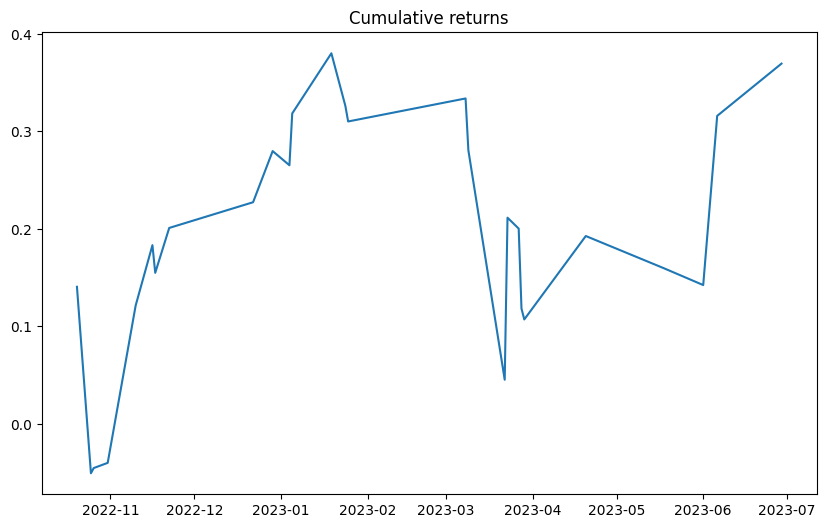

In [104]:
cum_rets = (1 + returns_df["returns"].loc[returns_df["returns"] < 0.2]).cumprod()-1
plt.figure(figsize=(10, 6))
plt.plot(returns_df.loc[returns_df["returns"] < 0.2].index, cum_rets)
plt.title("Cumulative returns")
plt.show()

<Axes: >

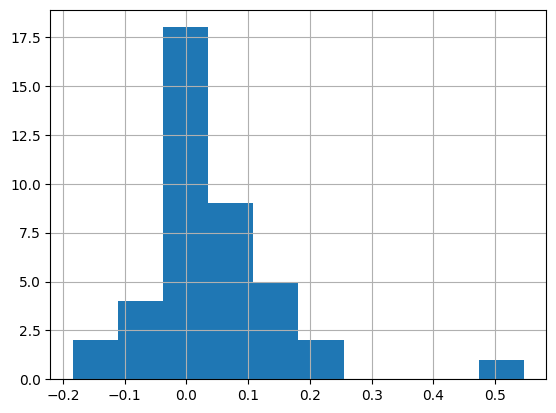

In [80]:
returns_df["returns"].hist()